In [70]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from netCDF4 import Dataset

import matplotlib.image as mpimg
from matplotlib import cm
import matplotlib.animation as ani
from scipy.integrate import odeint
import pandas as pd
import copy

from sklearn.linear_model import LinearRegression
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

%matplotlib inline

In [71]:
isotopes = Dataset('climatology/xnapa_isotopes.nc', "a")
precipitation = Dataset('climatology/xnapa_precip.nc', "a")
surface_temperature = Dataset('climatology/xnapa_temp.nc', "a")

In [72]:
lat = isotopes.variables["latitude"][:].data[1:-1]
long = isotopes.variables["longitude"][:].data
t = isotopes.variables["t"][:].data

trash = [626, 0]

In [73]:
def calculate_error(df_predictions, do18):  
    df_error = pd.DataFrame(columns=["mae", "mse"])
    for sample in range(len(df_predictions)):
        df_error.loc[sample, "mae"] = mean_absolute_error(do18.loc[sample].values, df_predictions.loc[sample].values)
    
    #print("Mean absolute error of test data:" ,df_error["mae"].mean())
    
    return df_error["mae"].mean()

In [74]:
t.shape

(1153,)

In [6]:
len(isotopes.variables["dO18"])

1153

In [7]:
do18 = []
precip = []
temp = []
for i in range(len(t)):
    do18.append(isotopes.variables["dO18"][i][0].data[1:-1].reshape(71*96))
    precip.append(precipitation.variables["precip"][i][0].data[1:-1].reshape(71*96))
    temp.append(surface_temperature.variables["temp_1"][i][0].data[1:-1].reshape(71*96))
    
do18 = pd.DataFrame(np.delete(np.delete(np.asarray(do18), 0, 0), 626, 0)[:1000])
precip = pd.DataFrame(np.delete(np.delete(np.asarray(precip), 0, 0), 626, 0)[:1000])
temp = pd.DataFrame(np.delete(np.delete(np.asarray(temp), 0, 0), 626, 0)[:1000])

In [8]:
from statsmodels.stats.weightstats import DescrStatsW

In [9]:
weights = np.cos(np.deg2rad(lat))
weights = weights/weights.sum()
weights = weights[:, np.newaxis] * np.ones_like(do18.mean().values.reshape(71,96))

In [14]:
def divide_data(temp: pd.DataFrame, precip: pd.DataFrame, do18: pd.DataFrame, train=0.9, random=True):
    
    if random:
        random_idx = np.random.permutation(do18.index.values)
    
        temp = temp.reindex(random_idx)
        precip = precip.reindex(random_idx)
        do18 = do18.reindex(random_idx)
    
    #divide training and test data
    do18_train = do18[:int(np.floor(train*len(do18)))].reset_index(drop=True)
    do18_test = do18[int(np.floor(train*len(do18))):].reset_index(drop=True)

    temp_train = temp[:int(np.floor(train*len(temp)))].reset_index(drop=True)
    temp_test = temp[int(np.floor(train*len(temp))):].reset_index(drop=True)

    precip_train = precip[:int(np.floor(train*len(precip)))].reset_index(drop=True)
    precip_test = precip[int(np.floor(train*len(precip))):].reset_index(drop=True)
    
    return do18_train, do18_test, temp_train, temp_test, precip_train, precip_test

In [15]:
def mlr_pca(
    temp: pd.DataFrame, precip: pd.DataFrame, do18: pd.DataFrame, 
    n_temp=20, n_precip=20, n_y=20, 
    train_proportion=0.9, random=True):
    
    do18_train, do18_test, temp_train, temp_test, precip_train, precip_test = divide_data(
        temp, precip, do18, train_proportion, random
    )
    
    #define scalers
    scaler_temp = StandardScaler().fit(temp)
    scaler_precip = StandardScaler().fit(precip)
    scaler_do18 = StandardScaler().fit(do18)
    
    #scale data
    do18_train_scaler = scaler_do18.transform(do18_train)
    do18_test_scaler = scaler_do18.transform(do18_test)

    temp_train_scaler = scaler_temp.transform(temp_train)
    temp_test_scaler = scaler_temp.transform(temp_test)

    precip_train_scaler = scaler_precip.transform(precip_train)
    precip_test_scaler = scaler_precip.transform(precip_test)
    
    #define pcas and fit data
    pca_temp = PCA(n_components=n_temp).fit(
        np.append(temp_train_scaler, temp_test_scaler, axis=0)
    )
    pca_precip = PCA(n_components=n_precip).fit(
        np.append(precip_train_scaler, precip_test_scaler, axis=0)
    )
    pca_do18 = PCA(n_components=n_y).fit(
        np.append(do18_train_scaler, do18_test_scaler, axis=0)
    )
    
    #transform data
    do18_train_pc = pca_do18.transform(do18_train_scaler)
    do18_test_pc = pca_do18.transform(do18_test_scaler)

    temp_train_pc = pca_temp.transform(temp_train_scaler)
    temp_test_pc = pca_temp.transform(temp_test_scaler)

    precip_train_pc = pca_precip.transform(precip_train_scaler)
    precip_test_pc = pca_precip.transform(precip_test_scaler)
    
    
    X_train = np.append(temp_train_pc, precip_train_pc, axis=1)
    X_test = np.append(temp_test_pc, precip_test_pc, axis=1)

    Y_train = do18_train_pc
    Y_test = pd.DataFrame(do18_test_pc)
        
    #train model
    regressor = LinearRegression().fit(X_train, Y_train)
    #Random Forest Regression: 
    #regressor = RandomForestRegressor().fit(X_train, Y_train.values.ravel())
    
    #predict test data
    pred_pc = pd.DataFrame(regressor.predict(X_test))
    #inverse transform predictions
    pred_norm = pd.DataFrame(pca_do18.inverse_transform(pred_pc))
    pred = pd.DataFrame(scaler_do18.inverse_transform(pred_norm))
    
    #return predictions and test data
    return pred_pc, pred_norm, pred, Y_test, pd.DataFrame(do18_test_scaler), do18_test

In [16]:
pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = mlr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)

In [8]:
calculate_error(pred, do18_test)

0.698785153592596

## Sign correlation

In [25]:
def calculate_sign_correlation(pred_norm, do18_test_scaler):
    sign_correlation = np.heaviside(pred_norm*do18_test_scaler, 0) 
    return sign_correlation

In [27]:
sign_correlation_total = calculate_sign_correlation(pred_norm, do18_test_scaler)
for i in range(100):
    pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = mlr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)
    corr = calculate_sign_correlation(pred_norm, do18_test_scaler)
    sign_correlation_total = sign_correlation_total.append(corr)
sign_correlation_total = sign_correlation_total.reset_index(drop=True)

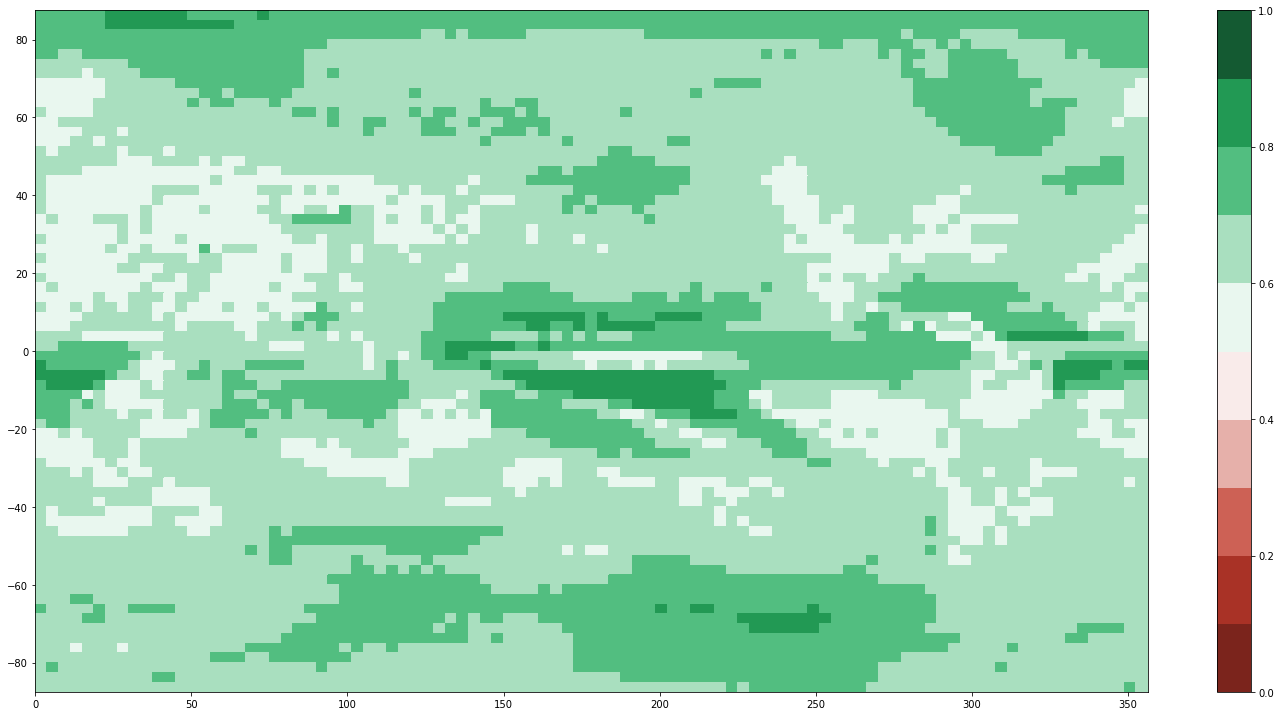

In [31]:
para = sign_correlation_total.mean().values.reshape(71,96)

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#7b241c", "#a93226", "#cd6155", "#e6b0aa", "#f9ebea", "#e9f7ef", "#a9dfbf", "#52be80", "#229954", "#145a32"]
cmap= matplotlib.colors.ListedColormap(colors)
norm= matplotlib.colors.Normalize(vmin=0,vmax=1)

plt.pcolor(long, lat, para,  cmap=cmap, vmin=0, vmax=1, norm=norm)
plt.tight_layout()
cbar = plt.colorbar()

In [32]:
pd.DataFrame(para).mean().values.mean()

0.6668489547018082

In [33]:
file = open("sign_correlation_mlr_pca.txt", "w")
dump = "\n".join(para.reshape(71*96).astype(str).tolist())
file.write(dump)

127819

## Mean deviation from mean values

In [12]:
pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = mlr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)

In [13]:
pred_list = copy.deepcopy(pred)
test_list = copy.deepcopy(do18_test)

In [14]:
for i in range(100):
    print(i)
    pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = mlr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)
    pred_list = pred_list.append(pred)
    test_list = test_list.append(do18_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99


In [15]:
pred_list = pred_list.reset_index(drop=True)
test_list = test_list.reset_index(drop=True)

In [14]:
rmse_geolist = []
for pixel in test_list.columns.values:
    rmse_pixel = mean_squared_error(pred_list[pixel].values, test_list[pixel].values, squared=False)
    rmse_geolist.append(rmse_pixel)

In [9]:
df_rmse_geolist = pd.DataFrame(np.asarray(rmse_geolist).reshape(71,96))

NameError: name 'rmse_geolist' is not defined

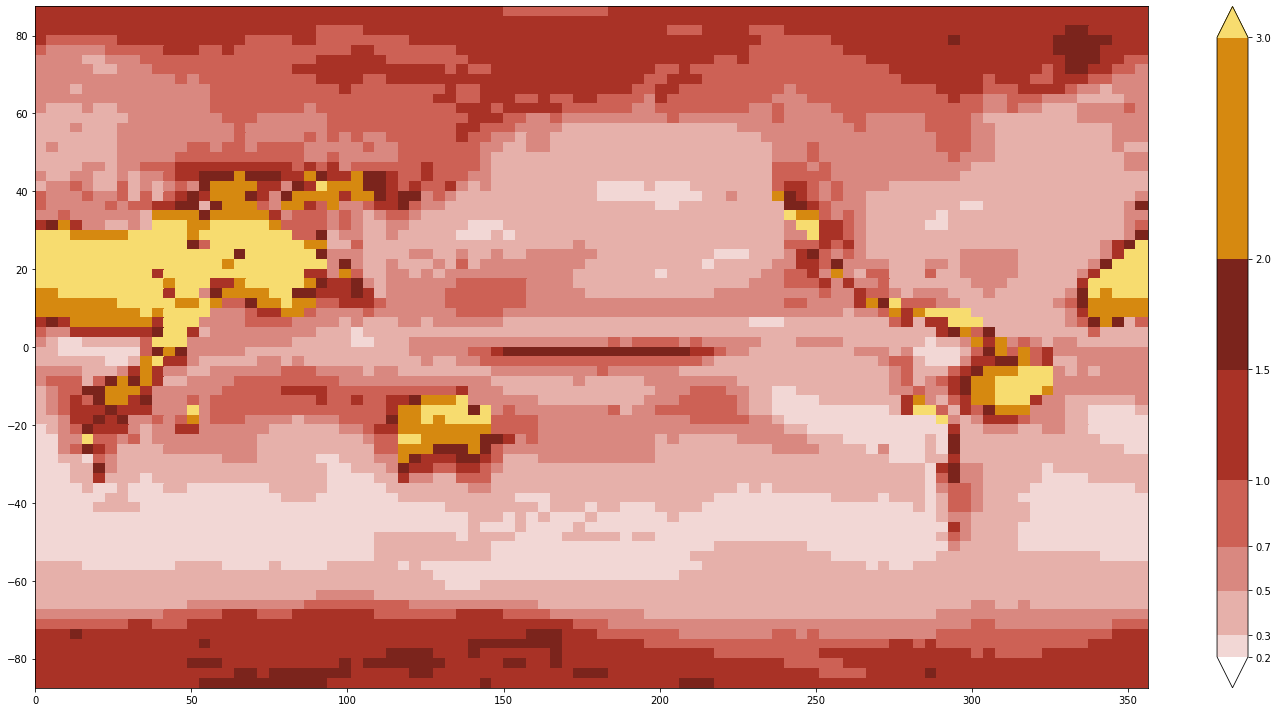

In [16]:
para = df_rmse_geolist.values

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#f2d7d5", "#e6b0aa", "#d98880", "#cd6155", "#a93226", "#7b241c", "#d68910"]
bounds = [0.2, 0.3, 0.5, 0.7, 1, 1.5, 2, 3]
cmap= matplotlib.colors.ListedColormap(colors)
cmap.set_under("#ffffff")
cmap.set_over("#f7dc6f")
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

layer = plt.pcolor(long, lat, para, cmap=cmap, vmin=0.1, vmax=3, norm=norm)
plt.tight_layout()

cbar = plt.colorbar(
    layer,
    extend="both", 
    ticks=bounds, 
    spacing='proportional'
)

In [201]:
file = open("rmse_mlr_pca.txt", "w")
dump = "\n".join(para.reshape(71*96).astype(str).tolist())
file.write(dump)

129718

In [91]:
std = pd.DataFrame(do18.std().values.reshape(71,96))

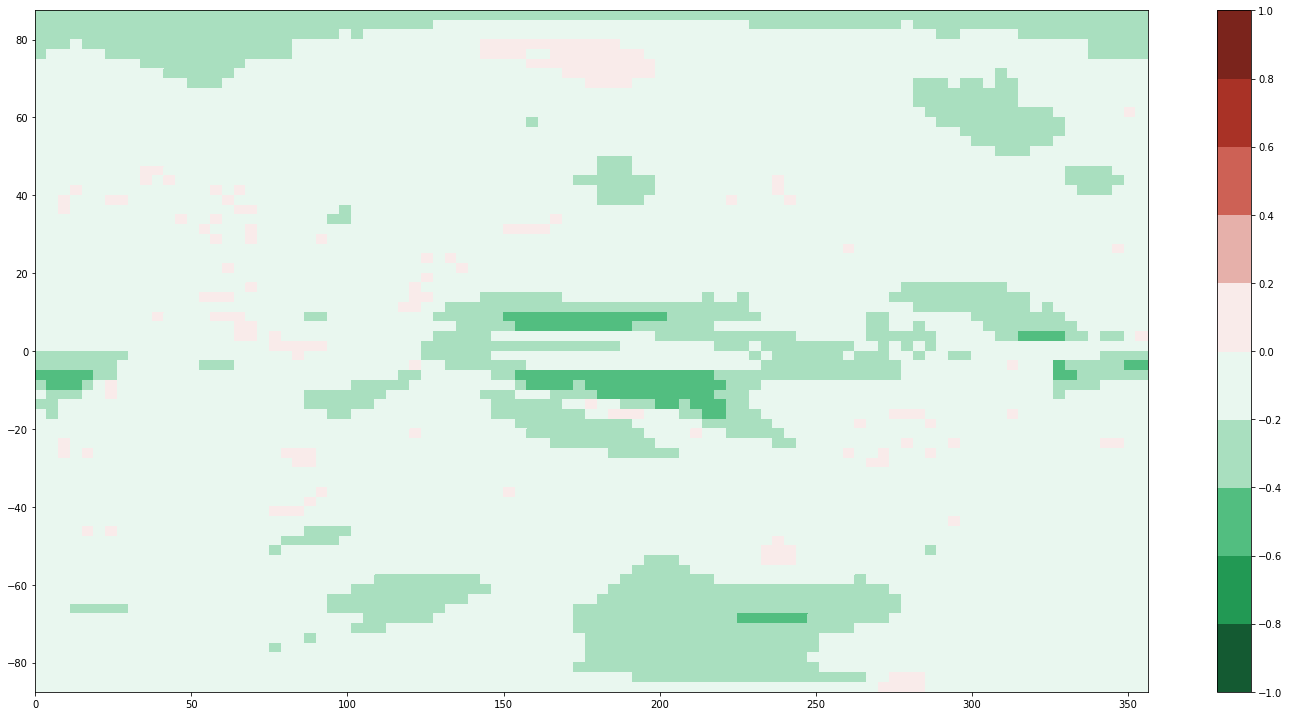

In [23]:
para = df_rmse_geolist/std -1

matplotlib.rcParams['figure.figsize'] = (20.0, 10.0)
fig = plt.figure()

colors = ["#145a32", "#229954", "#52be80", "#a9dfbf",  "#e9f7ef", "#f9ebea", "#e6b0aa", "#cd6155", "#a93226", "#7b241c"]
bounds = [-1, -0.8, -0.6, -0.4, -0.2, 0, 0.2, 0.4, 0.6, 0.8, 1] 
cmap= matplotlib.colors.ListedColormap(colors)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

layer = plt.pcolor(
    long, lat, para, 
    cmap=cmap,
    vmin=-1, vmax=1, 
    norm=norm
)
plt.tight_layout()

cbar = plt.colorbar(
    layer,
    ticks=bounds, 
    spacing='proportional'
)

In [26]:
file = open("rmse_norm_mlr_pca.txt", "w")
dump = "\n".join((df_rmse_geolist/std -1).values.reshape(71*96).astype(str).tolist())
file.write(dump)

142729

## RMSE over number of PC

In [ ]:
pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = mlr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20)

In [80]:
iss = [1, 2, 3, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 25, 27, 30, 35, 40, 45, 50, 60, 70, 80, 100, 120, 140, 160, 200, 250, 300, 350, 400, 450, 500, 600, 700, 800, 900]

In [28]:
rmse_list = []
rmse_pc = []
std_pc = []

for n_pc in iss:
    print("n_pc: {}".format(n_pc))
    pred_pc_n_pc, pred_norm_n_pc, pred_n_pc, Y_test_n_pc, do18_test_scaler_n_pc, do18_test_n_pc = mlr_pca(
        temp, precip, do18, n_temp=20, n_precip=20, n_y=n_pc
    )
    
    for j in range(15):
        pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = mlr_pca(
            temp, precip, do18, n_temp=20, n_precip=20, n_y=n_pc
        )
        pred_n_pc = pred_n_pc.append(pred)
        do18_test_n_pc = do18_test_n_pc.append(do18_test)
        
        pred_pc_n_pc = pred_pc_n_pc.append(pred_pc)
        Y_test_n_pc = Y_test_n_pc.append(Y_test)
        
    pred_n_pc = pred_n_pc.reset_index(drop=True)
    do18_test_n_pc = do18_test_n_pc.reset_index(drop=True)
    pred_pc_n_pc = pred_pc_n_pc.reset_index(drop=True)
    Y_test_n_pc = Y_test_n_pc.reset_index(drop=True)
    
    std_pc.append(Y_test_n_pc.std().values.mean())
    rmse_temp = []
    for pc in pred_pc_n_pc.columns.values:
        rmse = mean_squared_error(pred_pc_n_pc[pc].values, Y_test_n_pc[pc].values, squared=False)
        rmse_temp.append(rmse)

    rmse_pc.append(np.mean(rmse_temp))
    print(np.mean(rmse_temp)) ##################################
    print(Y_test_n_pc.std().values.mean()) ##############################
    
    rmse_geolist = []
    for pixel in do18_test_n_pc.columns.values:
        rmse_pixel = mean_squared_error(pred_n_pc[pixel].values, do18_test_n_pc[pixel].values, squared=False)
        rmse_geolist.append(rmse_pixel)
    
    df_rmse_geolist_n_pc = pd.DataFrame(np.asarray(rmse_geolist).reshape(71,96))
    rmse_list.append(df_rmse_geolist_n_pc.mean().mean())
    print(df_rmse_geolist_n_pc.mean().mean()) #############################
    print("")

n_pc: 1
6.345929483352004
17.763734710919344
0.9419888099029531

n_pc: 2
9.380783723177574
17.388674266967385
0.9312920743709353

n_pc: 3
6.845905465901122
16.641919142821354
0.9057926880968962

n_pc: 4
6.288927844700008
15.862982381796128
0.8923242222004326

n_pc: 6
6.94098728924141
14.661446064272269
0.8820476633572566

n_pc: 8
6.701597433046976
13.484654446285228
0.8712523600678974

n_pc: 10
8.332047912310903
12.776768922525495
0.8916247391876081

n_pc: 12
7.92581202128945
11.946108094378834
0.8872549427495948

n_pc: 14
5.290759354984307
11.308173514265262
0.838307022534638

n_pc: 16
6.140466713390158
11.01683016768313
0.8480502985817604

n_pc: 18
7.438383253889814
10.646006067396454
0.8743354388112946

n_pc: 20
6.34460149735801
10.213874068470629
0.8469555810447987

n_pc: 22
6.549769882780498
10.19019749990244
0.8510476864990291

n_pc: 25
6.225246960135044
9.49690109261448
0.8440294577877984

n_pc: 27
6.2837583440289455
9.241557990539091
0.8465103577513137

n_pc: 30
5.6318747601530

In [11]:
rmse_std_list = np.array(rmse_list)/(std.mean().mean())

In [75]:
with open("mlr_rmse_list.txt") as f:
    rmse_list = f.readlines()
rmse_list = np.asarray(rmse_list).astype(float)
rmse_list

array([0.94198881, 0.93129207, 0.90579269, 0.89232422, 0.88204766,
       0.87125236, 0.89162474, 0.88725494, 0.83830702, 0.8480503 ,
       0.87433544, 0.84695558, 0.85104769, 0.84402946, 0.84651036,
       0.82745533, 0.91996522, 0.874814  , 0.8852012 , 0.89258526,
       0.89691878, 0.86848433, 0.90482657, 0.82366177, 0.82429976,
       0.92300349, 0.81572833, 0.91676663, 0.87726104, 0.96702372,
       0.97180763, 0.97092452, 0.8943747 , 0.92560964, 0.88573432,
       0.89841024, 0.95067785, 0.94931674])

In [76]:
with open("mlr_rmse_std_list.txt") as f:
    rmse_std_list = f.readlines()
rmse_std_list = np.asarray(rmse_std_list).astype(float)
rmse_std_list

array([0.98261039, 0.97145237, 0.94485337, 0.9308041 , 0.92008438,
       0.90882355, 0.93007445, 0.92551622, 0.87445751, 0.88462094,
       0.91203958, 0.88347902, 0.88774759, 0.88042671, 0.8830146 ,
       0.86313786, 0.95963707, 0.91253878, 0.92337391, 0.9310764 ,
       0.93559679, 0.90593615, 0.94384559, 0.8591807 , 0.8598462 ,
       0.96280636, 0.85090515, 0.95630055, 0.91509135, 1.00872488,
       1.01371509, 1.01279389, 0.932943  , 0.96552489, 0.92393002,
       0.93715257, 0.99167413, 0.99025432])

In [77]:
with open("mlr_std_pc.txt") as f:
    std_pc = f.readlines()
std_pc = np.asarray(std_pc).astype(float)
std_pc

array([17.76373471, 17.38867427, 16.64191914, 15.86298238, 14.66144606,
       13.48465445, 12.77676892, 11.94610809, 11.30817351, 11.01683017,
       10.64600607, 10.21387407, 10.1901975 ,  9.49690109,  9.24155799,
        8.93825146,  8.56241043,  8.02504758,  7.66508622,  7.40299227,
        6.91503357,  6.54325619,  6.15215491,  5.64742792,  5.25312864,
        4.96235285,  4.64898645,  4.25356593,  3.88502513,  3.61574418,
        3.38819869,  3.18984817,  3.04931536,  2.89927165,  2.66529169,
        2.48391391,  2.3223393 ,  2.17648307])

In [78]:
with open("mlr_rmse_pc.txt") as f:
    rmse_pc = f.readlines()
rmse_pc = np.asarray(rmse_pc).astype(float)
rmse_pc

array([6.34592948, 9.38078372, 6.84590547, 6.28892784, 6.94098729,
       6.70159743, 8.33204791, 7.92581202, 5.29075935, 6.14046671,
       7.43838325, 6.3446015 , 6.54976988, 6.22524696, 6.28375834,
       5.63187476, 8.05766058, 6.77101324, 6.85931146, 6.81694225,
       6.5179362 , 5.80872965, 6.03746671, 4.62578975, 4.41289685,
       5.06694986, 3.98407887, 4.35689318, 3.78064358, 3.9104947 ,
       3.68563437, 3.47208316, 3.052889  , 3.00456262, 2.67682641,
       2.51828243, 2.45885597, 2.30113075])

In [81]:
error_pc = []
for n_pc in iss:
    scaler_do18 = StandardScaler().fit(do18)
    do18_scaler = scaler_do18.transform(do18)
    pca_do18 = PCA(n_components=n_pc).fit(do18_scaler)
    do18_pc = pca_do18.transform(do18_scaler)
    
    do18_inv = scaler_do18.inverse_transform(pca_do18.inverse_transform(do18_pc))
    error_pc.append(mean_squared_error(do18_inv, do18, squared=False))

In [14]:
rmse_pc

array([6.34592948, 9.38078372, 6.84590547, 6.28892784, 6.94098729,
       6.70159743, 8.33204791, 7.92581202, 5.29075935, 6.14046671,
       7.43838325, 6.3446015 , 6.54976988, 6.22524696, 6.28375834,
       5.63187476, 8.05766058, 6.77101324, 6.85931146, 6.81694225,
       6.5179362 , 5.80872965, 6.03746671, 4.62578975, 4.41289685,
       5.06694986, 3.98407887, 4.35689318, 3.78064358, 3.9104947 ,
       3.68563437, 3.47208316, 3.052889  , 3.00456262, 2.67682641,
       2.51828243, 2.45885597, 2.30113075])

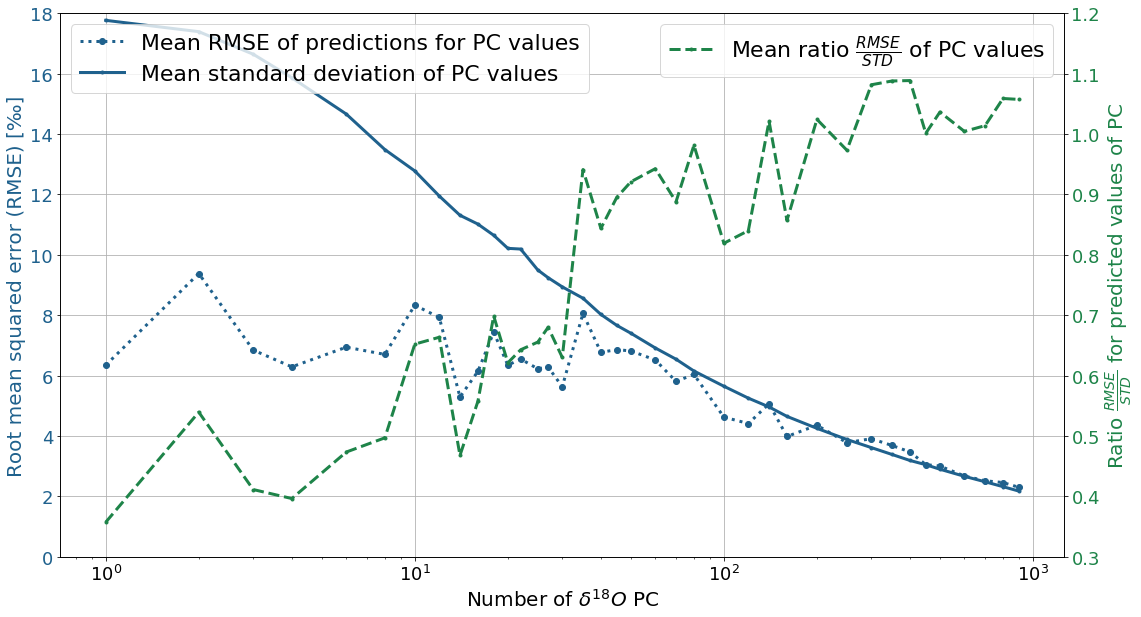

In [94]:
fig, ax1 = plt.subplots(figsize=(18,10))
ax2 = ax1.twinx()
ax1.set_xlabel("Number of $\delta^{18}O$ PC", fontsize=20)
ax1.set_xscale("log")

ax1.plot(iss, rmse_pc, "o:", color="#1f618d", linewidth=3, label="Mean RMSE of predictions for PC values")
ax1.plot(iss, std_pc, ".-", color="#1f618d", linewidth=3, label="Mean standard deviation of PC values")
ax1.tick_params(axis='y', labelcolor="#1f618d")
ax1.set_ylim(0,18)
ax1.set_ylabel("Root mean squared error (RMSE) [‰]", fontsize=20, color="#1f618d")
ax1.grid()
ax1.tick_params(labelsize=18)

ax2.set_ylabel(r"Ratio $\frac{RMSE}{STD}$ for predicted values of PC", fontsize=20, color="#1e8449")
ax2.plot(iss, rmse_pc/std_pc, ".--" ,color="#1e8449", linewidth=3, label=r"Mean ratio $ \frac{RMSE}{STD}$ of PC values")
ax2.set_ylim(0.3,1.2)
ax2.tick_params(axis='y', labelcolor="#1e8449")
ax2.tick_params(labelsize=18)

ax1.legend(fontsize=22, loc="upper left")
ax2.legend(fontsize=22, loc="upper right")

plt.savefig("figures/mlr_pca_npc_pc.png", bbox_inches="tight")
plt.show()

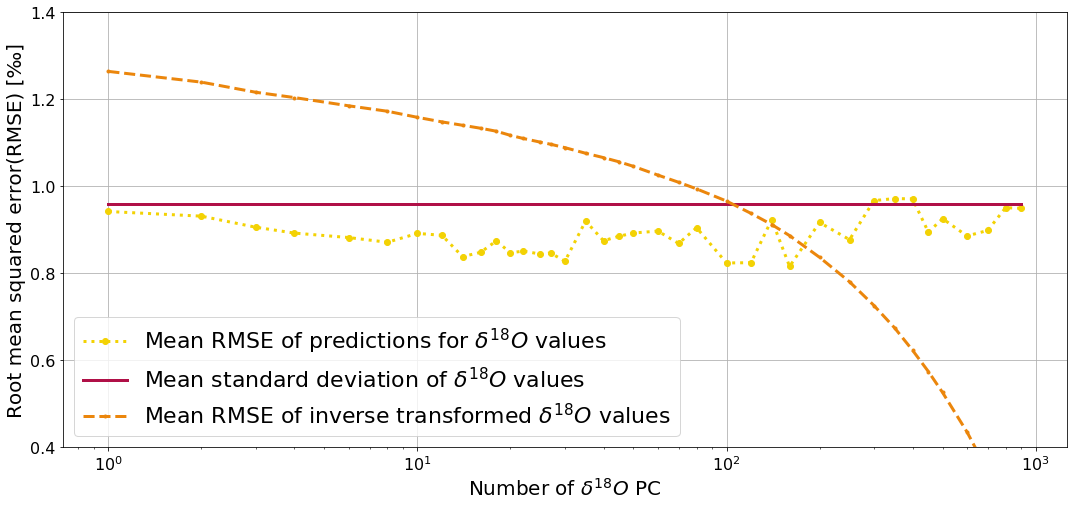

In [95]:
plt.figure(figsize=(18,8))

plt.xlabel("Number of $\delta^{18}O$ PC", fontsize=20)
plt.xscale("log")

plt.plot(iss, rmse_list, "o:", color="#f3d204", linewidth=3, label="Mean RMSE of predictions for $\delta^{18}O$ values")
plt.plot(iss, [std.mean().mean()]*len(iss), "-", color="#b01047", linewidth=3, label=r"Mean standard deviation of $\delta^{18}O$ values")
plt.plot(iss, error_pc, ".--", color="#eb860c", linewidth=3, label="Mean RMSE of inverse transformed $\delta^{18}O$ values")
plt.ylim(0.4,1.4)
plt.ylabel("Root mean squared error(RMSE) [‰]", fontsize=20)
plt.grid()


plt.legend(fontsize=22, loc="lower left")
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)

plt.savefig("figures/mlr_pca_npc.png", bbox_inches="tight")
plt.show()

## Time series

In [51]:
pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = mlr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20, random=False)

In [30]:
pred_list2 = copy.deepcopy(pred)
test_list2 = copy.deepcopy(do18_test)

In [31]:
dfs = [pred]
runs = 150
for i in range(runs):
    print(i)
    pred_pc, pred_norm, pred, Y_test, do18_test_scaler, do18_test = mlr_pca(temp, precip, do18, n_temp=20, n_precip=20, n_y=20, random=False)
    dfs.append(pred)
    pred_list2 = pred_list2.append(pred)
    test_list2 = test_list2.append(do18_test)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149


In [61]:
mean_year_values = []
year_std_values = []
for year in range(len(dfs[0])):
    year_values = pred_list2.loc[year].mean().values
    year_std = pred_list2.loc[year].std().values
    mean_year_values.append(year_values)
    year_std_values.append(year_std)

In [64]:
df_time_series = pd.DataFrame(mean_year_values)
df_time_series_std = pd.DataFrame(year_std_values)
df_time_series_std

,0,1,2,3,4,5,6,7,8,9,...,6806,6807,6808,6809,6810,6811,6812,6813,6814,6815
0,0.015112,0.014736,0.014471,0.014277,0.014044,0.014266,0.014093,0.014132,0.013989,0.013773,...,0.023440,0.024164,0.025061,0.025793,0.027111,0.028042,0.028515,0.028690,0.029753,0.030966
1,0.011285,0.011309,0.011373,0.011119,0.011020,0.011153,0.011201,0.011279,0.011225,0.011249,...,0.016299,0.017083,0.017655,0.017948,0.019309,0.020448,0.021329,0.021955,0.022586,0.023728
2,0.013956,0.014162,0.014349,0.014218,0.014010,0.014173,0.014184,0.014328,0.014335,0.014365,...,0.016405,0.016843,0.017454,0.018211,0.019171,0.020053,0.020747,0.021331,0.021862,0.022392
3,0.019675,0.019709,0.019570,0.019008,0.018723,0.018695,0.018537,0.018447,0.018314,0.018331,...,0.021783,0.022411,0.022845,0.023911,0.025021,0.026076,0.026666,0.027088,0.028139,0.029339
4,0.019149,0.019191,0.018994,0.018669,0.018448,0.018595,0.018425,0.018415,0.018178,0.018180,...,0.020367,0.020689,0.021005,0.022017,0.022460,0.023271,0.024074,0.024848,0.026013,0.027210
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.014759,0.014650,0.014377,0.014070,0.013795,0.014050,0.013679,0.013471,0.013182,0.013050,...,0.018500,0.019298,0.019917,0.020336,0.021619,0.022526,0.023148,0.023493,0.024328,0.025517
96,0.012527,0.012361,0.012233,0.011949,0.011806,0.011921,0.011890,0.011910,0.011798,0.011743,...,0.015857,0.016114,0.016510,0.017111,0.017535,0.017853,0.018150,0.018568,0.019278,0.020050
97,0.016210,0.016426,0.016513,0.016368,0.016183,0.016346,0.016361,0.016545,0.016514,0.016552,...,0.023382,0.023990,0.025071,0.026190,0.027727,0.029011,0.029282,0.029366,0.030329,0.031416
98,0.014693,0.014697,0.014771,0.014606,0.014412,0.014572,0.014386,0.014442,0.014403,0.014531,...,0.020333,0.020878,0.021752,0.022251,0.023242,0.024130,0.024822,0.025352,0.026460,0.027543


In [65]:
file = open("df_time_series.txt", "w")
dump = "\n".join(df_time_series.values.reshape(100*6816).astype(str).tolist())
file.write(dump)

file = open("df_time_series_std.txt", "w")
dump = "\n".join(df_time_series_std.values.reshape(100*6816).astype(str).tolist())
file.write(dump)

14266237

In [52]:
with open("df_time_series.txt") as f:
    df_time_series = f.readlines()
df_time_series = pd.DataFrame(np.asarray(df_time_series).astype(float).reshape(100,6816))

with open("df_time_series_std.txt") as f:
    df_time_series_std = f.readlines()
df_time_series_std = pd.DataFrame(np.asarray(df_time_series_std).astype(float).reshape(100,6816))

In [53]:
with open("sign_correlation_mlr_pca.txt") as f:
    sign_correlation_mlr_pca = f.readlines()
sign_correlation_mlr_pca = np.asarray(sign_correlation_mlr_pca).astype(float)
sign_correlation_mlr_pca

array([0.78514851, 0.7890099 , 0.79326733, ..., 0.67693069, 0.67910891,
       0.67712871])

In [54]:
print(sign_correlation_mlr_pca[556])

0.6845544554455446


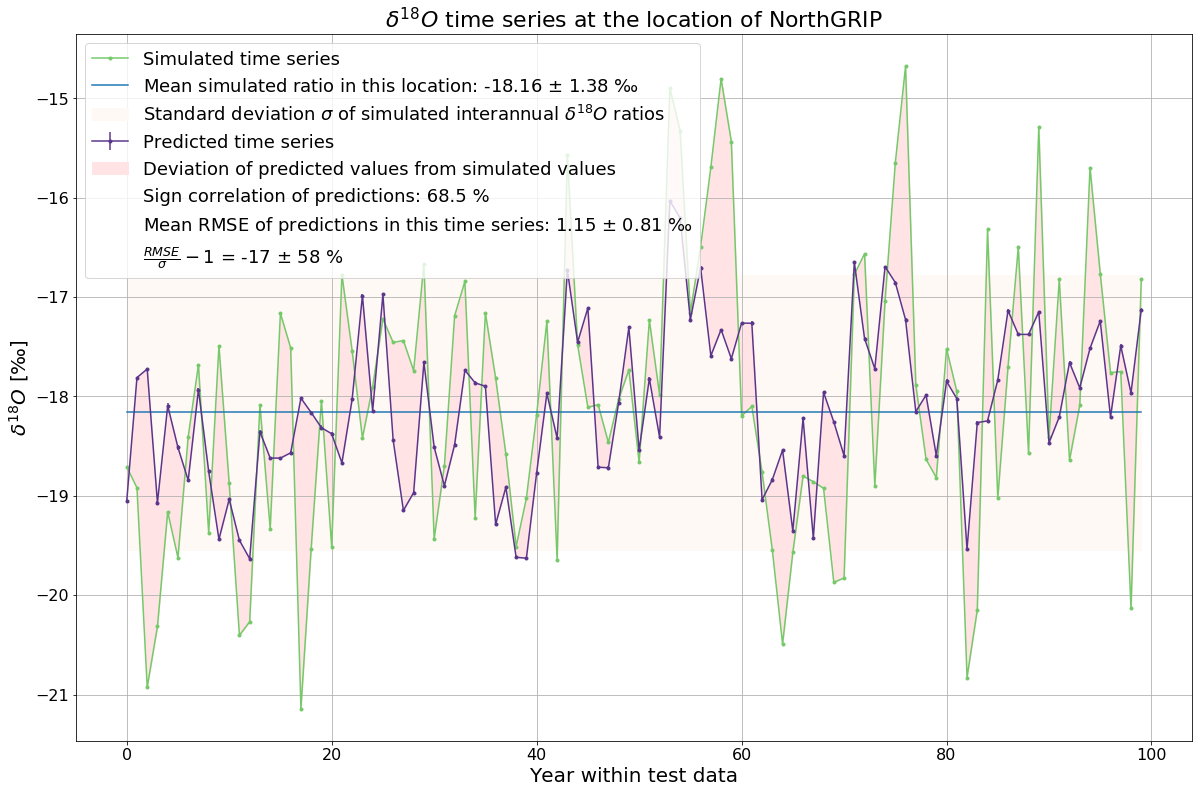

In [66]:
x = 556
plt.figure(figsize=(20,13))
#plt.plot([], [], ' ', label="$NorthGRIP$")

plt.errorbar(np.arange(100), df_time_series[x].values, fmt=".-",
             yerr=df_time_series_std[x].values, color="#5a358c", label="Predicted time series")


plt.plot(do18_test[x].values, ".-", color="#74c969", label="Simulated time series")
plt.plot(np.arange(0,100), [do18[x].values.mean()]*100, 
         label=r"Mean simulated ratio in this location: {:.2f} $\pm$ {:.2f} ‰".format(
             do18[x].values.mean(),
             do18[x].values.std()
         ))
plt.fill_between(np.arange(100), do18[x].values.mean()+do18[x].values.std() , do18[x].values.mean()-do18[x].values.std(),
                 color="#fef9f4", 
                 label="Standard deviation $\sigma$ of simulated interannual $\delta^{18}O$ ratios")
plt.grid()
plt.xlabel("Year within test data", fontsize=20)
plt.ylabel("$\delta^{18}O$ [‰]", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

li = []
for i in range(len(do18_test[x].values)):
    squared_error = (df_time_series[x].values[i] - do18_test[x].values[i])**2
    li.append(squared_error)
li = np.asarray(li)

rmse_x = np.sqrt(li.mean())
rmse_x_std = li.std()/(2*rmse_x)

plt.plot([], [], ' ', label="Sign correlation of predictions: {:.1f} %".format(
    sign_correlation_mlr_pca[x]*100
))
plt.plot([], [], ' ', label="Mean RMSE of predictions in this time series: {:.2f} $\pm$ {:.2f} ‰".format(
    rmse_x, rmse_x_std
))

frac = r"$\frac{RMSE}{\sigma}-1$"
label = frac + " = {:.0f} $\pm$ {:.0f} %".format(
    (rmse_x/do18[x].std()-1)*100,
    abs(rmse_x_std/do18[x].std())*100
)

plt.plot([], [], ' ', label=label)


plt.fill_between(np.arange(100), df_time_series[x].values, do18_test[x].values, color="#ffe3e5", 
                 label="Deviation of predicted values from simulated values")

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,5,7,6,2,3,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=18)

plt.title(r"$\delta^{18}O$ time series at the location of NorthGRIP", fontsize=22)

plt.savefig("figures/series_ngrip.png", bbox_inches="tight")
plt.show()

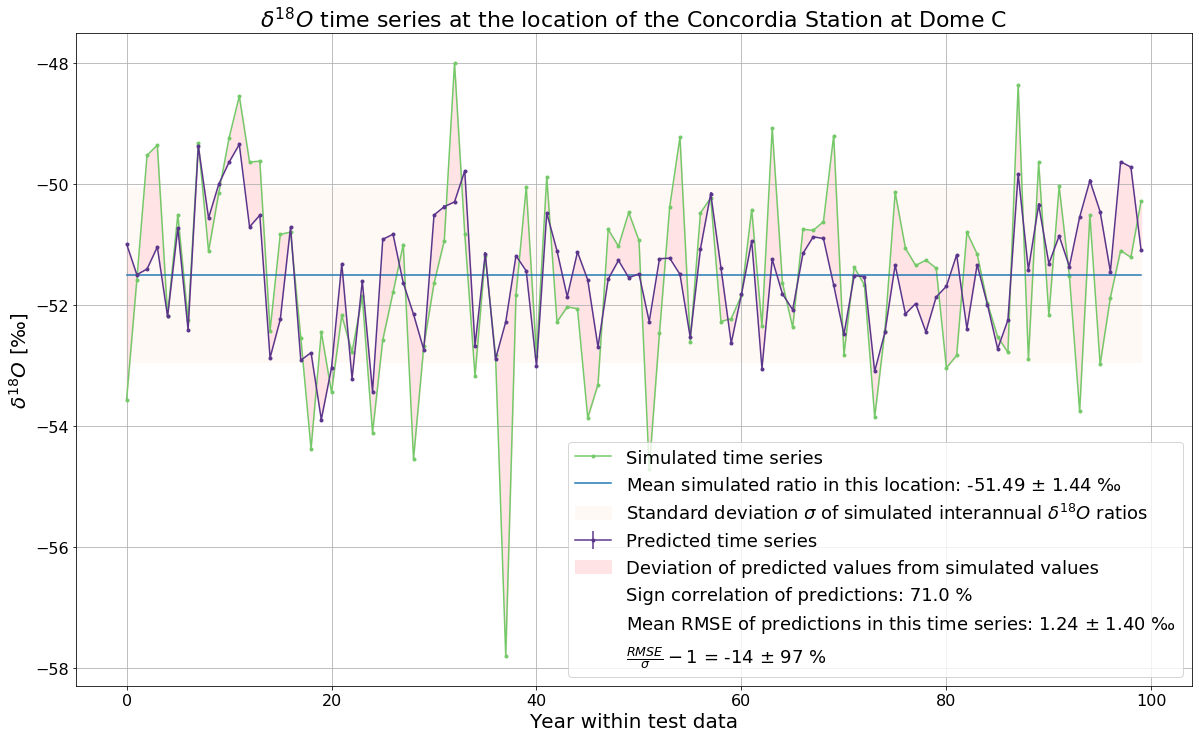

In [64]:
x = 6270
plt.figure(figsize=(20,12))
#plt.plot([], [], ' ', label="$Dome$ $C$")

plt.errorbar(np.arange(100), df_time_series[x].values, fmt=".-",
             yerr=df_time_series_std[x].values, color="#5a358c", label="Predicted time series")


plt.plot(do18_test[x].values, ".-", color="#74c969", label="Simulated time series")
plt.plot(np.arange(0,100), [do18[x].values.mean()]*100, 
         label=r"Mean simulated ratio in this location: {:.2f} $\pm$ {:.2f} ‰".format(
             do18[x].values.mean(),
             do18[x].values.std()
         ))
plt.fill_between(np.arange(100), do18[x].values.mean()+do18[x].values.std() , do18[x].values.mean()-do18[x].values.std(),
                 color="#fef9f4", 
                 label="Standard deviation $\sigma$ of simulated interannual $\delta^{18}O$ ratios")
plt.grid()
plt.xlabel("Year within test data", fontsize=20)
plt.ylabel("$\delta^{18}O$ [‰]", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

li = []
for i in range(len(do18_test[x].values)):
    squared_error = (df_time_series[x].values[i] - do18_test[x].values[i])**2
    li.append(squared_error)
li = np.asarray(li)

rmse_x = np.sqrt(li.mean())
rmse_x_std = li.std()/(2*rmse_x)

plt.plot([], [], ' ', label="Sign correlation of predictions: {:.1f} %".format(
    sign_correlation_mlr_pca[x]*100
))
plt.plot([], [], ' ', label="Mean RMSE of predictions in this time series: {:.2f} $\pm$ {:.2f} ‰".format(
    rmse_x, rmse_x_std
))

frac = r"$\frac{RMSE}{\sigma}-1$"
label = frac + " = {:.0f} $\pm$ {:.0f} %".format(
    (rmse_x/do18[x].std()-1)*100,
    abs(rmse_x_std/do18[x].std())*100
)

plt.plot([], [], ' ', label=label)


plt.fill_between(np.arange(100), df_time_series[x].values, do18_test[x].values, color="#ffe3e5", 
                 label="Deviation of predicted values from simulated values")

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,5,7,6,2,3,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=18)
plt.title(r"$\delta^{18}O$ time series at the location of the Concordia Station at Dome C", fontsize=22)

plt.savefig("figures/series_domec.png", bbox_inches="tight")
plt.show()

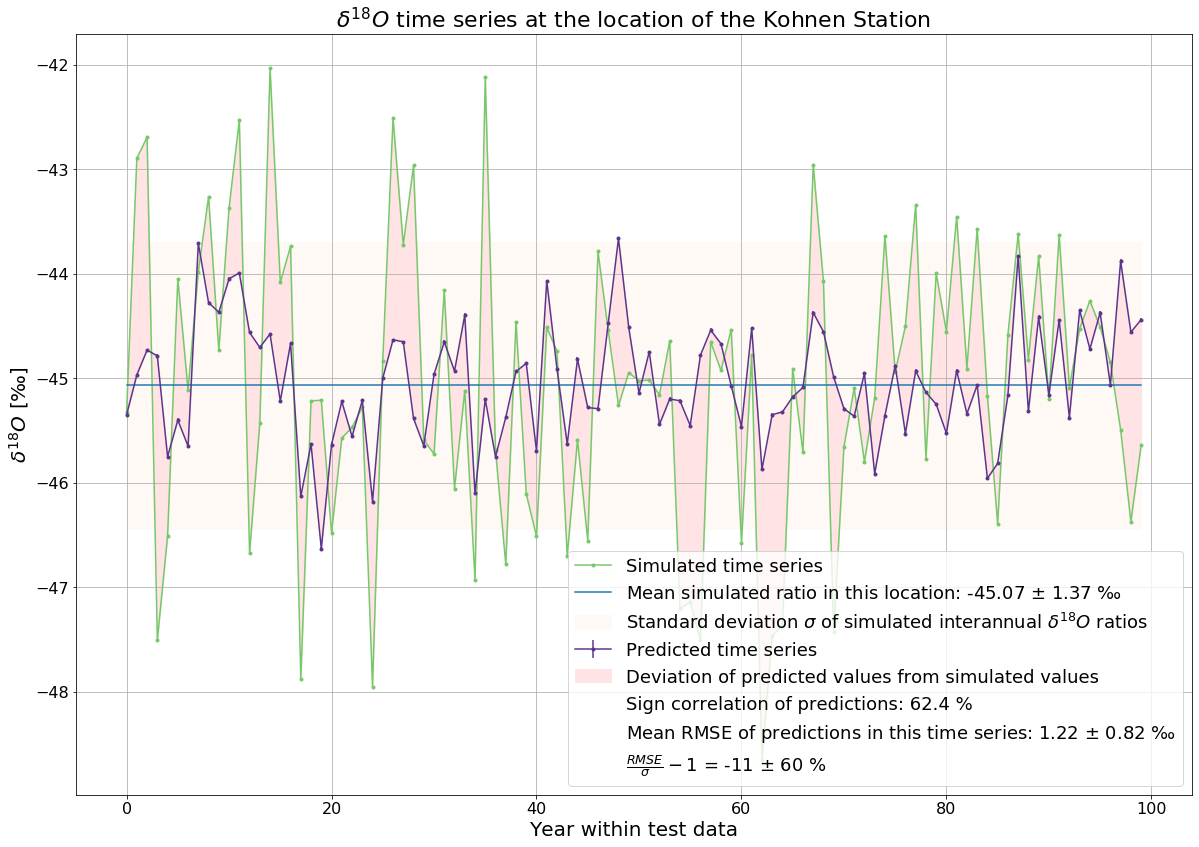

In [65]:
x = 6240
plt.figure(figsize=(20,14))
#plt.plot([], [], ' ', label="$Kohnen$ $station$")

plt.errorbar(np.arange(100), df_time_series[x].values, fmt=".-",
             yerr=df_time_series_std[x].values, color="#5a358c", label="Predicted time series")


plt.plot(do18_test[x].values, ".-", color="#74c969", label="Simulated time series")
plt.plot(np.arange(0,100), [do18[x].values.mean()]*100, 
         label=r"Mean simulated ratio in this location: {:.2f} $\pm$ {:.2f} ‰".format(
             do18[x].values.mean(),
             do18[x].values.std()
         ))
plt.fill_between(np.arange(100), do18[x].values.mean()+do18[x].values.std() , do18[x].values.mean()-do18[x].values.std(),
                 color="#fef9f4", 
                 label="Standard deviation $\sigma$ of simulated interannual $\delta^{18}O$ ratios")
plt.grid()
plt.xlabel("Year within test data", fontsize=20)
plt.ylabel("$\delta^{18}O$ [‰]", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

li = []
for i in range(len(do18_test[x].values)):
    squared_error = (df_time_series[x].values[i] - do18_test[x].values[i])**2
    li.append(squared_error)
li = np.asarray(li)

rmse_x = np.sqrt(li.mean())
rmse_x_std = li.std()/(2*rmse_x)

plt.plot([], [], ' ', label="Sign correlation of predictions: {:.1f} %".format(
    sign_correlation_mlr_pca[x]*100
))
plt.plot([], [], ' ', label="Mean RMSE of predictions in this time series: {:.2f} $\pm$ {:.2f} ‰".format(
    rmse_x, rmse_x_std
))

frac = r"$\frac{RMSE}{\sigma}-1$"
label = frac + " = {:.0f} $\pm$ {:.0f} %".format(
    (rmse_x/do18[x].std()-1)*100,
    abs(rmse_x_std/do18[x].std())*100
)

plt.plot([], [], ' ', label=label)


plt.fill_between(np.arange(100), df_time_series[x].values, do18_test[x].values, color="#ffe3e5", 
                 label="Deviation of predicted values from simulated values")

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,5,7,6,2,3,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=18)
plt.title(r"$\delta^{18}O$ time series at the location of the Kohnen Station", fontsize=22)

plt.savefig("figures/series_kohnen.png", bbox_inches="tight")
plt.show()

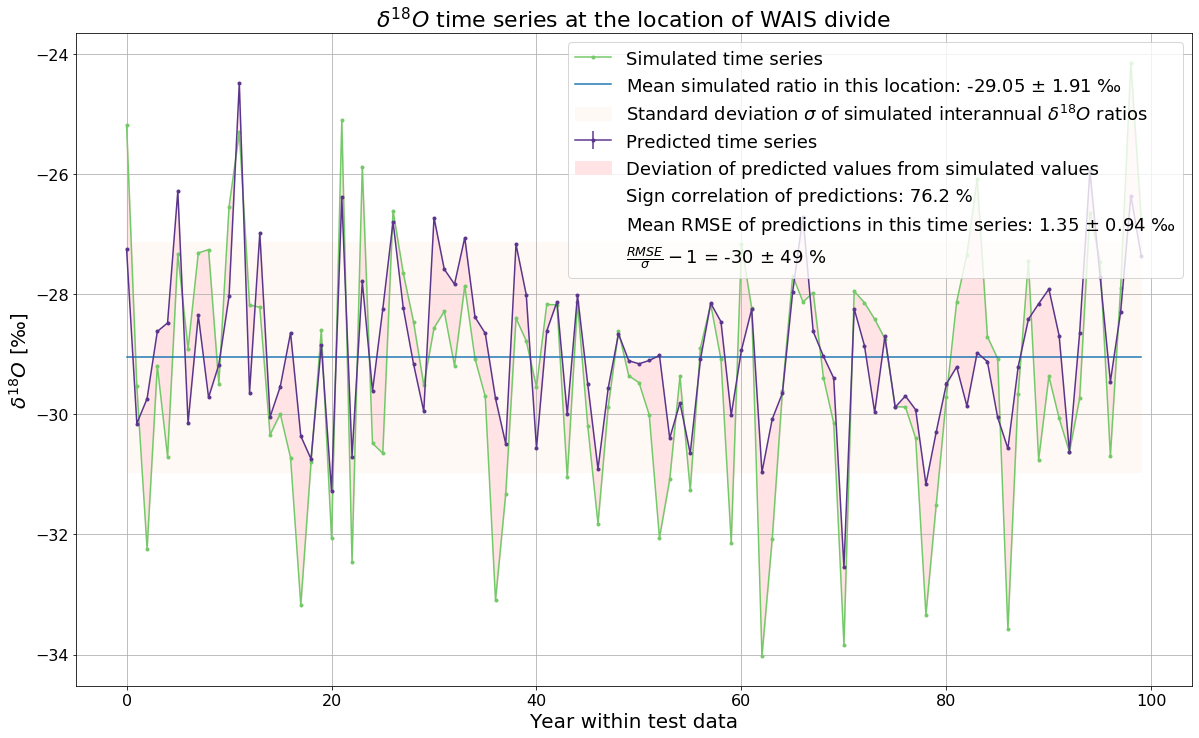

In [69]:
x = 6491
plt.figure(figsize=(20,12))
#plt.plot([], [], ' ', label="$WAIS$ $divide$")

plt.errorbar(np.arange(100), df_time_series[x].values, fmt=".-",
             yerr=df_time_series_std[x].values, color="#5a358c", label="Predicted time series")


plt.plot(do18_test[x].values, ".-", color="#74c969", label="Simulated time series")
plt.plot(np.arange(0,100), [do18[x].values.mean()]*100, 
         label=r"Mean simulated ratio in this location: {:.2f} $\pm$ {:.2f} ‰".format(
             do18[x].values.mean(),
             do18[x].values.std()
         ))
plt.fill_between(np.arange(100), do18[x].values.mean()+do18[x].values.std() , do18[x].values.mean()-do18[x].values.std(),
                 color="#fef9f4", 
                 label="Standard deviation $\sigma$ of simulated interannual $\delta^{18}O$ ratios")
plt.grid()
plt.xlabel("Year within test data", fontsize=20)
plt.ylabel("$\delta^{18}O$ [‰]", fontsize=20)
plt.xticks(fontsize=16)
plt.yticks(fontsize=16)

li = []
for i in range(len(do18_test[x].values)):
    squared_error = (df_time_series[x].values[i] - do18_test[x].values[i])**2
    li.append(squared_error)
li = np.asarray(li)

rmse_x = np.sqrt(li.mean())
rmse_x_std = li.std()/(2*rmse_x)

plt.plot([], [], ' ', label="Sign correlation of predictions: {:.1f} %".format(
    sign_correlation_mlr_pca[x]*100
))
plt.plot([], [], ' ', label="Mean RMSE of predictions in this time series: {:.2f} $\pm$ {:.2f} ‰".format(
    rmse_x, rmse_x_std
))

frac = r"$\frac{RMSE}{\sigma}-1$"
label = frac + " = {:.0f} $\pm$ {:.0f} %".format(
    (rmse_x/do18[x].std()-1)*100,
    abs(rmse_x_std/do18[x].std())*100
)

plt.plot([], [], ' ', label=label)


plt.fill_between(np.arange(100), df_time_series[x].values, do18_test[x].values, color="#ffe3e5", 
                 label="Deviation of predicted values from simulated values")

handles, labels = plt.gca().get_legend_handles_labels()
order = [0,1,5,7,6,2,3,4]
plt.legend([handles[idx] for idx in order],[labels[idx] for idx in order], fontsize=18, loc="upper right")
plt.title(r"$\delta^{18}O$ time series at the location of WAIS divide", fontsize=22)


plt.savefig("figures/series_wais.png", bbox_inches="tight")
plt.show()